# Positive Count Grabber

In [5]:
from helpers.processors import csv_to_positive_articles, schools_pipeline_query_to_csv
from helpers.processors import positive_articles_to_sentences
from helpers.processors import preprocess_text
import pandas as pd
import numpy as np
from helpers.queries import count_query
school_names=['UCF']
pipeline=[]
string = "Hillel"

csv_path = 'grouped_data/csv/'
csv_file = csv_path+'UCF_Hillel.csv'
df = schools_pipeline_query_to_csv(school_names=school_names, pipeline=pipeline, query=count_query(string), csv_file=csv_file)
df = csv_to_positive_articles(csv_file)
print(df)

grouped_data/csv/UCF_Hillel.csv already exists.
     school        date                             txt_file
49      UCF  2009-09-14  journal_data/txt/UCF/2009_09_14.txt
290     UCF  2010-09-10  journal_data/txt/UCF/2010_09_10.txt
864     UCF  2012-12-03  journal_data/txt/UCF/2012_12_03.txt
1463    UCF  2014-12-11  journal_data/txt/UCF/2014_12_11.txt
1485    UCF  2015-01-13  journal_data/txt/UCF/2015_01_13.txt
1968    UCF  2016-09-02  journal_data/txt/UCF/2016_09_02.txt
2042    UCF  2016-11-28  journal_data/txt/UCF/2016_11_28.txt
2207    UCF  2017-10-06  journal_data/txt/UCF/2017_10_06.txt
2339    UCF  2018-04-12  journal_data/txt/UCF/2018_04_12.txt
2481    UCF  2019-01-18  journal_data/txt/UCF/2019_01_18.txt
2491    UCF  2019-01-29  journal_data/txt/UCF/2019_01_29.txt
2526    UCF  2019-03-22  journal_data/txt/UCF/2019_03_22.txt
2559    UCF  2019-06-22  journal_data/txt/UCF/2019_06_22.txt


Theoretical text processing, to be used in the case of pdf text.

In [4]:
# Load in the data
import nltk
nltk.download('wordnet')

txt_list = positive_articles_to_sentences(df=df, string=string)
proc_txt_list = [preprocess_text(txt) for txt in txt_list]
process_checker = pd.DataFrame([txt_list, proc_txt_list]).transpose()
process_checker.columns = ["Raw", "Processed"]
process_checker.to_csv("example_processed_text.csv", index=False)

Fetching all associated text:

In [6]:
import json

with open('ucf_article_pages.json', 'r') as f:
    ucf_article_pages = json.load(f)

df['links'] = df.apply(lambda row: ucf_article_pages[row['date'].replace('-','_')], axis=1)

def split_text(row):
    with open(row['txt_file'], 'r', encoding='utf-8') as f:
        text = f.read()
    return text.split('\n\n\n')[:-1]

df['text'] = df.apply(split_text, axis=1)

for index, row in df.iterrows():
    if len(row['text']) == len(row['links']):
        print(f"Row {index}: Length of 'text' matches length of 'links'")
    else:
        print(f"Row {index}: Length of 'text' does not match length of 'links'")


Row 49: Length of 'text' matches length of 'links'
Row 290: Length of 'text' matches length of 'links'
Row 864: Length of 'text' matches length of 'links'
Row 1463: Length of 'text' matches length of 'links'
Row 1485: Length of 'text' matches length of 'links'
Row 1968: Length of 'text' matches length of 'links'
Row 2042: Length of 'text' matches length of 'links'
Row 2207: Length of 'text' matches length of 'links'
Row 2339: Length of 'text' matches length of 'links'
Row 2481: Length of 'text' matches length of 'links'
Row 2491: Length of 'text' matches length of 'links'
Row 2526: Length of 'text' matches length of 'links'
Row 2559: Length of 'text' matches length of 'links'


In [7]:
count_query(string)
def matching_text(row):
    indices = [count_query(string)(text) for text in row['text']]
    new_text = [value for value, index in zip(row['text'], indices) if index != 0]
    return new_text
df['matching_text'] = df.apply(matching_text, axis=1)

def matching_links(row):
    indices = [count_query(string)(text) for text in row['text']]
    new_text = [value for value, index in zip(row['links'], indices) if index != 0]
    return new_text
df['matching_links'] = df.apply(matching_links, axis=1)

for index, row in df.iterrows():
    print(f"Row {index}: Has {len(row['matching_text'])} text entries satisfying the query")

Row 49: Has 1 text entries satisfying the query
Row 290: Has 1 text entries satisfying the query
Row 864: Has 1 text entries satisfying the query
Row 1463: Has 1 text entries satisfying the query
Row 1485: Has 1 text entries satisfying the query
Row 1968: Has 1 text entries satisfying the query
Row 2042: Has 1 text entries satisfying the query
Row 2207: Has 1 text entries satisfying the query
Row 2339: Has 1 text entries satisfying the query
Row 2481: Has 1 text entries satisfying the query
Row 2491: Has 1 text entries satisfying the query
Row 2526: Has 1 text entries satisfying the query
Row 2559: Has 1 text entries satisfying the query


In [4]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [18]:
def compute_sentiment(row):
    text_entries = row['matching_text']
    print("Working with new text.")
    scores = []
    for text_entry in text_entries:
        positive_score, negative_score, neutral_score = get_sentiment(text=text_entry, string=string)
        scores.append((positive_score, negative_score, neutral_score))
    print(np.average(scores, axis=0))
    return np.average(scores, axis=0)

def get_sentiment(text, string):
    sequence_to_classify = text
    candidate_labels = ['positive', 'negative', 'neutral']
    classifications =  classifier(sequence_to_classify, candidate_labels, multiclass=True)
    positive = classifications['scores'][0]
    negative = classifications['scores'][1]
    neutral = classifications['scores'][2]
    return positive, negative, neutral

df[['positive', 'negative', 'neutral']] = df.apply(compute_sentiment, axis=1, result_type='expand')

df[['date','positive','negative','neutral']]

Working with new text.
[0.71365637 0.15632616 0.13001743]
Working with new text.
[0.50968158 0.26351428 0.22680414]
Working with new text.
[0.829651   0.09694474 0.07340428]
Working with new text.
[0.45335978 0.33679894 0.20984128]
Working with new text.
[0.53048331 0.37153843 0.09797829]
Working with new text.
[0.48928857 0.28078896 0.22992246]
Working with new text.
[0.52025664 0.2686069  0.21113645]
Working with new text.
[0.78222322 0.15011905 0.06765771]
Working with new text.
[0.71974218 0.19362761 0.08663019]
Working with new text.
[0.55483234 0.23562039 0.20954727]
Working with new text.
[0.51175964 0.35069335 0.137547  ]
Working with new text.
[0.59615535 0.31889629 0.08494841]
Working with new text.
[0.65279996 0.2575379  0.08966215]


,date,positive,negative,neutral
49,2009-09-14,0.713656,0.156326,0.130017
290,2010-09-10,0.509682,0.263514,0.226804
864,2012-12-03,0.829651,0.096945,0.073404
1463,2014-12-11,0.453360,0.336799,0.209841
1485,2015-01-13,0.530483,0.371538,0.097978
1968,2016-09-02,0.489289,0.280789,0.229922
2042,2016-11-28,0.520257,0.268607,0.211136
2207,2017-10-06,0.782223,0.150119,0.067658
2339,2018-04-12,0.719742,0.193628,0.086630
2481,2019-01-18,0.554832,0.235620,0.209547


In [19]:

df[['date','positive','negative','neutral']].to_csv('base_sentiment_results.csv')

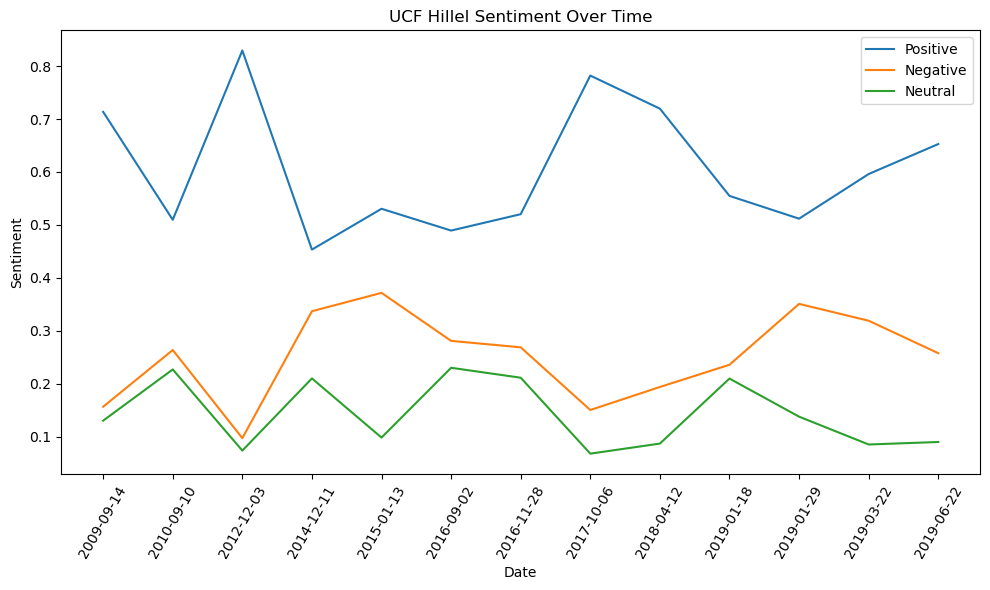

In [24]:
import matplotlib.pyplot as plt

def plot_sentiment_over_time(df):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data
    ax.plot(df['date'], df['positive'], label='Positive')
    ax.plot(df['date'], df['negative'], label='Negative')
    ax.plot(df['date'], df['neutral'], label='Neutral')

    # Set the title and axis labels
    ax.set_title(f'UCF {string} Sentiment Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment')
    
    # Rotate x-axis tick labels for better visibility
    plt.xticks(rotation=60)

    # Add a legend
    ax.legend()

    # Adjust the figure layout
    fig.tight_layout()

    # Save the plot
    plt.savefig('base_sentiment_results.png', bbox_inches='tight')

    # Show the plot
    plt.show()
    

plot_sentiment_over_time(df)